# Описание:  
По заказу фермерского хозяйста из предоставленных им данных (три файла) необходимо подобрать для покупки удовлетворяющих жестким критериям: удой не менее 6 т.\г. и качество молока "вкусное".  
В работе будет необходимо подготовить данные, провести их анализ, обучить модели и провести расчёт.

# 0. Подготовительные шаги и функции  


## Загружаю библиотеки и объявляю константы

In [54]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean 
import numpy as np
import math
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix





RANDOM_STATE = 42
DF_NAMES = ['df_cow', 'df_main', 'df_dad']

COW_CAT_COL = {'breed':'Порода', 'pasture_type':'Тип пастбища', 'breed_dad':'Порода отца', 'dad_name':'Кличка отца', 'age':'Возраст'}
MAIN_CAT_COL = {'breed':'Порода', 'pasture_type':'Тип пастбища', 'breed_dad':'Порода отца', 'taste':'Вкус', 'age':'Возраст'}
DAD_CAT_COL = {'dad_name':'Кличка'}

COW_NUM_COL = {'fat_per':'Процент жирности', 'protein_per':'Проценты белка'}
MAIN_NUM_COL = {'yield':'Удой', 'eke':'Энергетическая кормовая единица', 'protein_weight':'Содержание сырого протеина в корме (г.)', 'spo':'Сахаро-протеиновое соотношение', 'fat_per':'Процент жирности', 'protein_per':'Процент белка'}

df_metrics = df = pd.DataFrame(columns=['mse', 'mae', 'rmse'])


## Функция обучения модели линейной регрессии

In [55]:
def model_func(df, xcolumns, num_col,cat_col):
    X_train, X_test, y_train, y_test = tts(
        df[xcolumns], 
        df['yield'], 
        random_state=RANDOM_STATE
    )
    encoder = OneHotEncoder(sparse_output = False)
    scaler = StandardScaler()
    X_train = np.concatenate((scaler.fit_transform(X_train[num_col]), 
                              encoder.fit_transform(X_train[cat_col])), axis=1)
    X_test = np.concatenate((scaler.transform(X_test[num_col]), 
                             encoder.transform(X_test[cat_col])), axis=1)
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predict = model_lr.predict(X_test)
    metrics = [mean_squared_error(y_true=y_test, y_pred=predict),
               mean_absolute_error(y_true=y_test, y_pred=predict),
               root_mean_squared_error(y_true=y_test, y_pred=predict)]
    return predict, X_test, y_test, metrics, model_lr, scaler, encoder


## Функция логической регрессии

In [56]:
def cat_model_func(df, num_col, cat_col, y_col, threshold=0.5):
    encoder = OneHotEncoder(sparse_output = False)
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = tts(
    df[num_col + cat_col], 
    df[y_col], 
    random_state=RANDOM_STATE
    )
#  LabelEncoder().fit_transform
    if (num_col!=[]) & (cat_col!=[]):
        X_train = np.hstack([scaler.fit_transform(X_train[num_col]), 
                              encoder.fit_transform(X_train[cat_col])])
        X_test = np.hstack([scaler.transform(X_test[num_col]), 
                             encoder.transform(X_test[cat_col])])
    if (num_col ==[]):
        X_train = encoder.fit_transform(X_train[cat_col])
        X_test = encoder.transform(X_test[cat_col])
    if (cat_col ==[]):
        X_train = scaler.fit_transform(X_train[num_col])
        X_test = scaler.transform(X_test[num_col])

    clf = LogisticRegression().fit(X_train, y_train)
    predict = (clf.predict_proba(X_test)[:, 1] > threshold).astype('float')
    #print(X_train,X_test,y_train,y_test, clf.predict_proba(X_test))
    cm = confusion_matrix(y_test, predict)
    accuracy = accuracy_score(y_test, predict)
    recall = recall_score(y_test, predict,pos_label=1) 
    precision = precision_score(y_test, predict,pos_label=1) 
    y_proba = clf.predict_proba(X_test)[:,1]
    porog = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by = 'y_proba', ascending = False) 
    return encoder, scaler, accuracy, recall, precision, cm, porog, clf

# 1. Предобработка данных

### Для выполнения задачи заказчиком были переданы три набора данных  
 - ferma_main.csv - содержит данные о стаде на данный момент;  
 - ferma_dad.csv - содержит клички быков родителей каждой коровы в стаде фермера;  
 - cow_buy.csv - данне о коровах "ЭкоФермы" предложенных к покупке заказчиком;  
 В ходе дальнейших действий я произведу манипуляции с данными подготавливая их для дальнейших операций.

### Загружаю данные из файлов в датафреймы. Т.к. работу выполнял локально добавил проверку.

In [57]:
try:
    df_cow=pd.read_csv('c:/ps/project/happy_farm/data/cow_buy.csv', sep=';', decimal=",")
    df_main=pd.read_csv('c:/ps/project/happy_farm/data/ferma_main.csv', sep=';', decimal=",")
    df_dad=pd.read_csv('c:/ps/project/happy_farm/data/ferma_dad.csv', sep=';', decimal=",")
except:
    df_cow=pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=",")
    df_main=pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=",")
    df_dad=pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=",")

В файлах использовался не стандартный разделитель, пришлось добавить разделитель. Указал разделитель для дробных данных, чтобы иметь возможность их корректно обрабатывать.

##### Выведу пять случайных строк каждой таблицы, чтобы посмотреть на их содержимое.

In [58]:
display(df_cow.sample(5))
display(df_main.sample(5))
display(df_dad.sample(5))

Порода Тип пастбища порода папы_быка  Имя_папы  \
18   Вис Бик Айдиал    равнинное          Соверин    Буйный   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный   
17  РефлешнСоверинг    равнинное          Соверин  Геркулес   
11  РефлешнСоверинг    равнинное          Соверин  Геркулес   
14  РефлешнСоверинг    равнинное          Соверин     Барин   

    Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
18                3.34                    3.069  более_2_лет  
4                 3.64                    3.074  более_2_лет  
17                3.77                    3.053  менее_2_лет  
11                3.73                    3.073  более_2_лет  
14                3.59                    3.074  более_2_лет

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
263  264      6477                                   16.3              2191   
196  197      6366                                   14.6              2125   
516  517      5650                                   11.9              2200   
479  480      5535                                   11.8              1683   
35    36      6401                                   16.4              1768   

     СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
263                                  0.95  РефлешнСоверинг    Холмистое   
196                                  0.93   Вис Бик Айдиал    Холмистое   
516                                  0.85   Вис Бик Айдиал    Холмистое   
479                                  0.84   Вис Бик Айдиал    Равнинное   
35                                   0.93  РефлешнСоверинг    Холмистое   

    порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
263          Соверин        3.72    3.078      вкусно  более_2_лет  
196           Айдиал        3.62    3.077   не вкусно  более_2_лет  
516           Айдиал        3.23    3.079      вкусно  более_2_лет  
479          Соверин        3.22    3.077   не вкусно  менее_2_лет  
35           Айдиалл        3.71    3.073      вкусно  более_2_лет

id  Имя Папы
493  494  Соловчик
543  544    Буйный
553  554     Барин
50    51  Геркулес
166  167  Соловчик

# 2. Предобработка данных

## Посмотрю соответствие типов столбцов описанным в задаче типам.

In [59]:
display(df_cow.info(True))
display(df_main.info(True))
display(df_dad.info(True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

Можно заметить, что пропусков в столбцах нет.  
Формат столбцов не соответствует хранимым в них данным. Именование столбцов тоже мне не подходят. Изменю тип даннх столбцов немного позже - после переименования столбцов.

## Проверю именование столбцов

In [60]:
display('COW - table')
display(df_cow.columns.tolist())
display('MAIN - table')
display(df_main.columns.tolist())
display('DAD - table')
display(df_dad.columns.tolist())

'COW - table'

['Порода',
 'Тип пастбища',
 'порода папы_быка',
 'Имя_папы',
 'Текущая_жирность,%',
 'Текущий_уровень_белок,%',
 'Возраст']

'MAIN - table'

['id',
 'Удой, кг',
 'ЭКЕ (Энергетическая кормовая единица)',
 'Сырой протеин, г',
 'СПО (Сахаро-протеиновое соотношение)',
 'Порода',
 'Тип пастбища',
 'порода папы_быка',
 'Жирность,%',
 'Белок,%',
 'Вкус молока',
 'Возраст']

'DAD - table'

['id', 'Имя Папы']

Именование столбцов не соттветсвует требованиям. Переименовываю.

In [61]:
df_cow.columns = ['breed',
                  'pasture_type',
                  'breed_dad',
                  'dad_name',
                  'fat_per',
                  'protein_per',
                  'age']
df_main.columns = ['id',
                   'yield',
                   'eke',
                   'protein_weight',
                   'spo',
                   'breed',
                   'pasture_type',
                   'breed_dad',
                   'fat_per',
                   'protein_per',
                   'taste',
                   'age']
df_dad.columns = ['id', 
                  'dad_name']



## Меняю тип данных столбцов в соответствии с таблицей:  

**df_cow**
| Имя столбца    | Тип данных  | Новый тип данных |
|:---------------|:-----------:|:----------------:|
| breed          | object      | object           |
| pasture_type   | object      | object           |
| breed_dad      | object      | object           |
| dad_name       | object      | object           |
| fat_per        | object      | float64          |
| protein_per    | object      | float64          |
| age            | object      | object           |  

**df_main**
| Имя столбца    | Тип данных  | Новый тип данных |
|:---------------|:-----------:|:----------------:|
| id             | int64       | int64            |
| yield          | int64       | int64            |
| eke            | object      | float64          |
| protein_weight | int64       | int64            |
| spo            | object      | float64          |
| breed          | object      | object           |
| pasture_type   | object      | object           |
| breed_dad      | object      | object           |
| fat_per        | object      | float64          |
| protein_per    | object      | float64          |
| taste          | object      | object           |
| age            | object      | object           |  

**df_dad**
| Имя столбца    | Тип данных  | Новый тип данных |
|:---------------|:-----------:|:----------------:|
| id             | object      | int64            |
| name           | object      | object           |

In [62]:
df_cow = df_cow.astype({
    'fat_per': float,
    'protein_per': float
    
})

df_main = df_main.astype({
    'eke': float,
    'spo': float,
    'fat_per': float,
    'protein_per': float
})

df_dad = df_dad.astype({
    'id': float    
})

## Проверю таблицы на дубликаты

##### Выведу список явных дубликатов

In [63]:
for d in DF_NAMES:
    print(f'В {d} найдено дубликатов: {globals()[d].duplicated().sum()}')

В df_cow найдено дубликатов: 4
В df_main найдено дубликатов: 5
В df_dad найдено дубликатов: 0


###### Удаляю явные дубликаты

In [64]:
for d in DF_NAMES:
    globals()[d] = globals()[d].drop_duplicates()

##### Проверю на наличие неявных дубликатов у нечисловых столбцов

In [65]:
for d in DF_NAMES:
    if 'cow' in d: c_a = COW_CAT_COL.keys()
    if 'main' in d: c_a = MAIN_CAT_COL.keys()
    if 'dad' in d: c_a = DAD_CAT_COL.keys()
    for c in c_a:    
        print(f'Список уникальных значений таблицы {d} столбца {c}: {globals()[d][c].unique()}')

Список уникальных значений таблицы df_cow столбца breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Список уникальных значений таблицы df_cow столбца pasture_type: ['холмистое' 'равнинное']
Список уникальных значений таблицы df_cow столбца breed_dad: ['Айдиал' 'Соверин']
Список уникальных значений таблицы df_cow столбца dad_name: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Список уникальных значений таблицы df_cow столбца age: ['более_2_лет' 'менее_2_лет']
Список уникальных значений таблицы df_main столбца breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Список уникальных значений таблицы df_main столбца pasture_type: ['Равнинное' 'Равнинные' 'Холмистое']
Список уникальных значений таблицы df_main столбца breed_dad: ['Айдиал' 'Соверин' 'Айдиалл']
Список уникальных значений таблицы df_main столбца taste: ['вкусно' 'не вкусно']
Список уникальных значений таблицы df_main столбца age: ['более_2_лет' 'менее_2_лет']
Список уникальных значений таблицы df_dad столбца dad_name: ['Буйный' 'Соловчик' 'Барин' '

Наблюдаю задвоенные значения:  
_Список уникальных значений тамблицы df_main столбца pasture_type: ['Равнинное' 'Равнинные' 'Холмистое']_   
_Список уникальных значений таблицы df_main столбца breed_dad: ['Айдиал' 'Соверин' 'Айдиалл']_
_Список уникальных значений таблицы df_cow столбца breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']_
_Список уникальных значений таблицы df_main столбца breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']_


Заменю **Равнинные** на **Равнинное**  
И все значения содержащие **Айдиал** на **Айдиал**

In [66]:
df_main.loc[df_main['pasture_type'] == 'Равнинные', 'pasture_type'] = 'Равнинное'
df_main.loc[df_main['breed'].str.contains('Айдиал'), 'breed'] = 'Айдиал'
df_main.loc[df_main['breed_dad'].str.contains('Айдиал'), 'breed_dad'] = 'Айдиал'
df_cow.loc[df_cow['breed'].str.contains('Айдиал'), 'breed'] = 'Айдиал'
df_cow.loc[df_cow['breed_dad'].str.contains('Айдиал'), 'breed_dad'] = 'Айдиал'

## Вывод:  
Из полученных файлов от заказчика данные были загружены в три таблицы. Именование столбцов не соответствовало требованиям для проведения дальнейших работ - исправлено. Тип данных в столбцах не соответствовал хранимым в них данным - исправлено. Явных дубликатов было единичное количество и они удалены. Дубликаты вызванные человеческим фактором исправлены.

# 3. Исследовательский анализ данных

### Выведу описательную статистику по каждой таблице

In [67]:
print(f'Таблица DF_COW')
print(df_cow.describe())
print(f'Таблица DF_MAIN')
print(df_main.describe())


Таблица DF_COW
         fat_per  protein_per
count  16.000000    16.000000
mean    3.571875     3.068250
std     0.141620     0.011264
min     3.340000     3.046000
25%     3.415000     3.059500
50%     3.585000     3.073500
75%     3.692500     3.076750
max     3.770000     3.081000
Таблица DF_MAIN
              id         yield         eke  protein_weight         spo  \
count  629.00000    629.000000  629.000000      629.000000  629.000000   
mean   315.00000   6188.750397   14.543879     1923.364070    0.913116   
std    181.72094   1644.795489    1.306408      182.956251    0.032203   
min      1.00000   5204.000000   10.900000     1660.000000    0.840000   
25%    158.00000   5751.000000   13.500000     1771.000000    0.890000   
50%    315.00000   6133.000000   14.700000     1888.000000    0.930000   
75%    472.00000   6501.000000   15.600000     2062.000000    0.940000   
max    629.00000  45616.000000   16.800000     2349.000000    0.960000   

          fat_per  protein_per  

Получив описательную статистику можно заметить аномалии в удое на ферме заказчика. Скорее всего это опечатка.  

Выведу удои больше 8000 кг\год

In [68]:
display(df_main[df_main['yield'] > 8000])

id  yield   eke  protein_weight   spo   breed pasture_type breed_dad  \
16  17  45616  11.5            1675  0.93  Айдиал    Холмистое    Айдиал   

    fat_per  protein_per   taste          age  
16     3.22        3.076  вкусно  более_2_лет

Подтвердилось. Это единичная опечатка. Удалю ее  и выведу статистику.

In [69]:
df_main = df_main.drop(df_main[df_main['yield'] > 8000].index)
df_main.describe()

id        yield         eke  protein_weight         spo  \
count  628.000000   628.000000  628.000000      628.000000  628.000000   
mean   315.474522  6125.968153   14.548726     1923.759554    0.913089   
std    181.475367   475.857053    1.301777      182.832816    0.032221   
min      1.000000  5204.000000   10.900000     1660.000000    0.840000   
25%    158.750000  5749.750000   13.500000     1771.750000    0.890000   
50%    315.500000  6132.500000   14.700000     1888.000000    0.930000   
75%    472.250000  6501.000000   15.600000     2062.250000    0.940000   
max    629.000000  7222.000000   16.800000     2349.000000    0.960000   

          fat_per  protein_per  
count  628.000000   628.000000  
mean     3.604268     3.075670  
std      0.168093     0.002551  
min      2.990000     3.069000  
25%      3.590000     3.074000  
50%      3.650000     3.076000  
75%      3.720000     3.077000  
max      3.750000     3.085000

### Построю графики

#### Категориальные признаки

Гистограмма распределения значений для таблицы df_cow


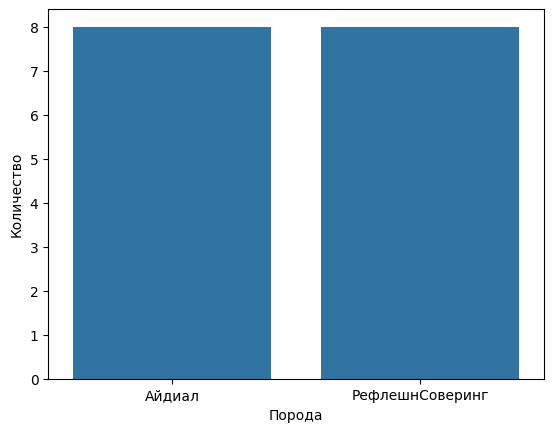

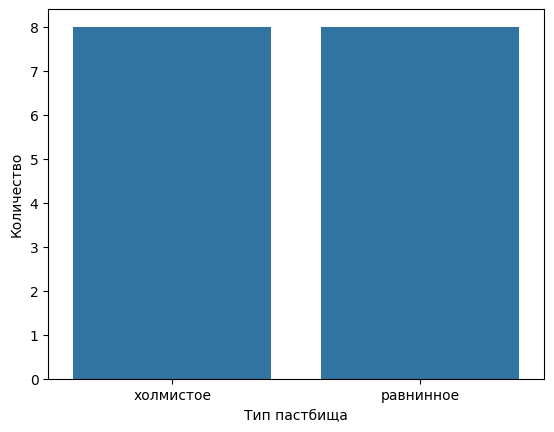

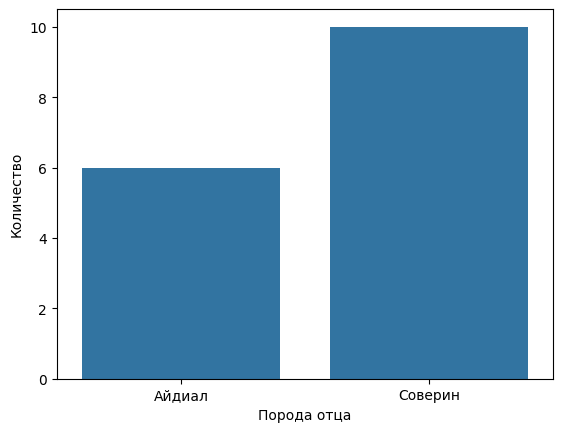

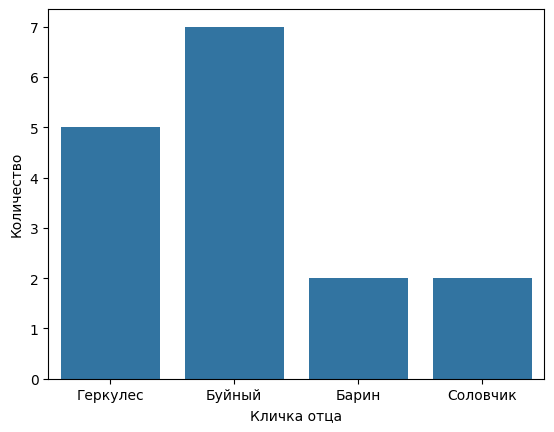

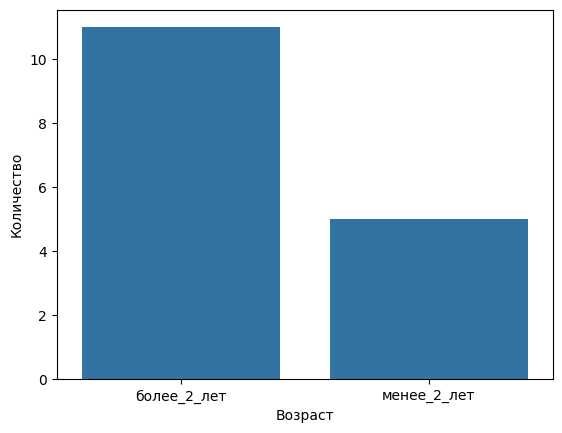

Гистограмма распределения значений для таблицы df_main


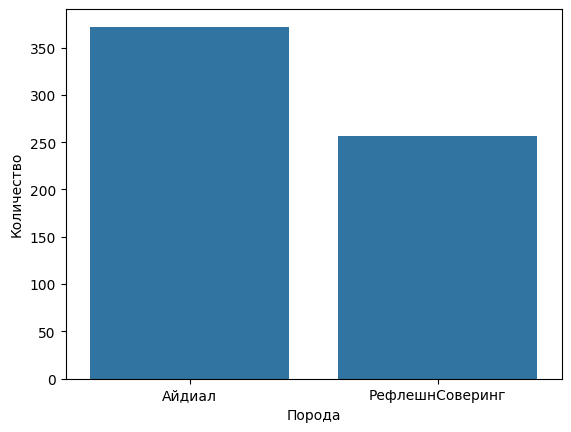

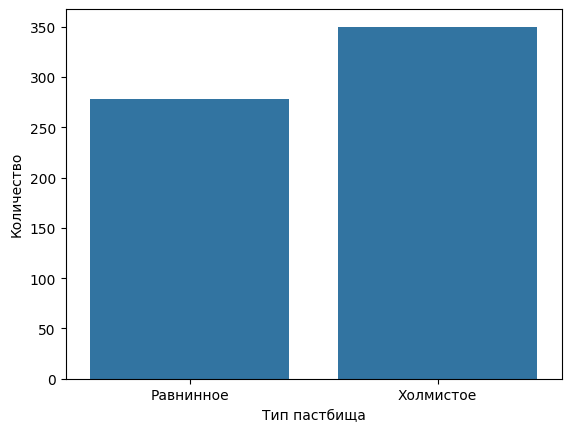

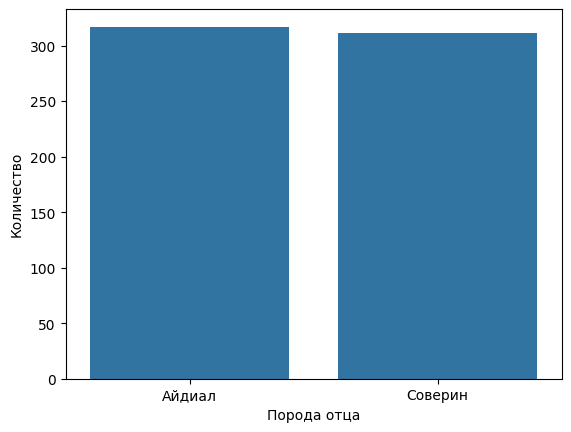

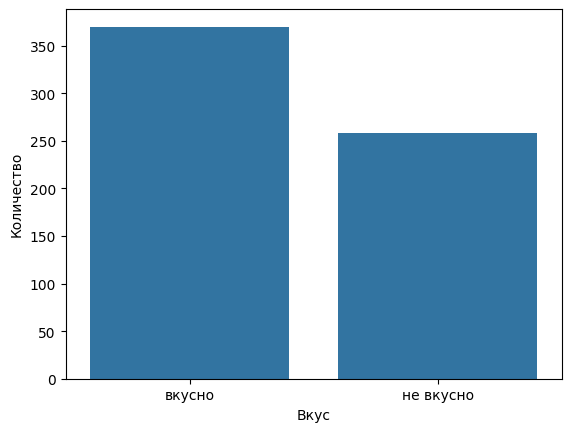

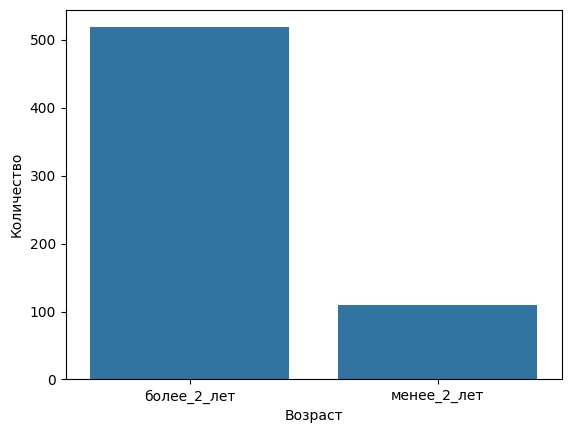

Гистограмма распределения значений для таблицы df_dad


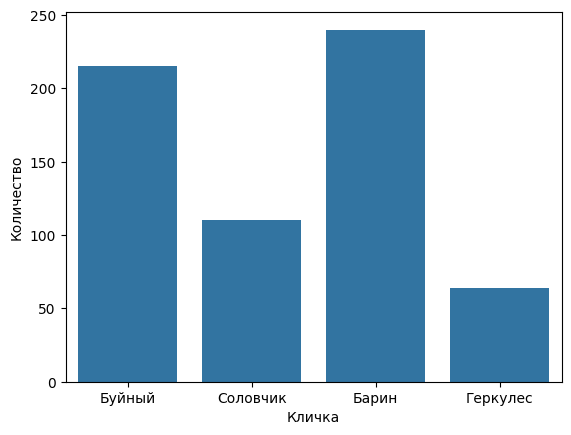

In [70]:
# для каждой таблицы создам константу содержащую перчень столбцов с категориальными признаками

for d in DF_NAMES:
    if 'cow' in d: c_a = COW_CAT_COL
    if 'main' in d: c_a = MAIN_CAT_COL
    if 'dad' in d: c_a = DAD_CAT_COL
    print(f'Гистограмма распределения значений для таблицы {d}')
    for c in c_a:
        ax = sns.countplot(x=c, data = globals()[d])
        ax.set(xlabel=c_a[c], ylabel='Количество')
        plt.show()


##### Количественные признаки

"Ящик с усами" для таблицы df_cow


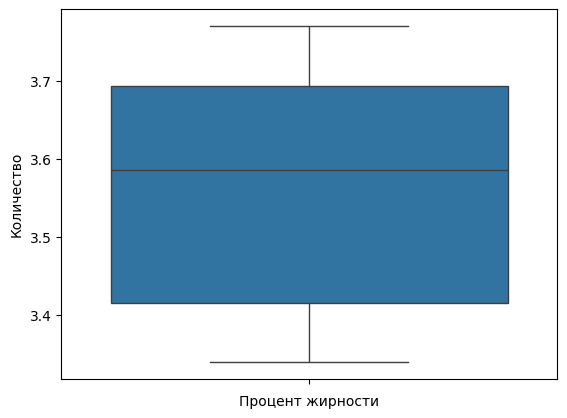

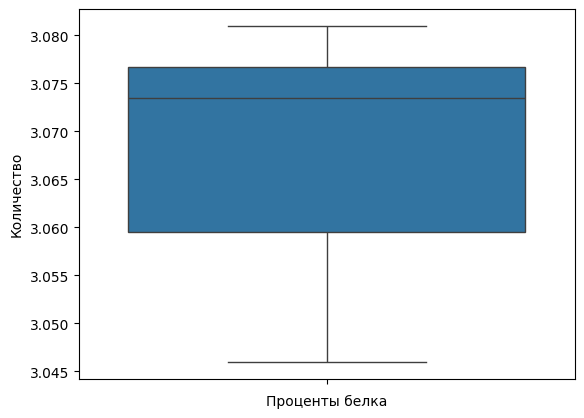

"Ящик с усами" для таблицы df_main


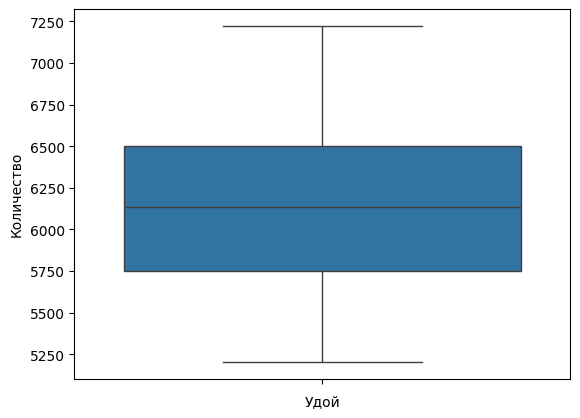

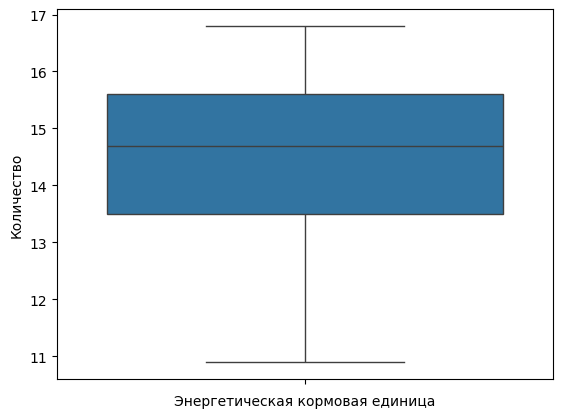

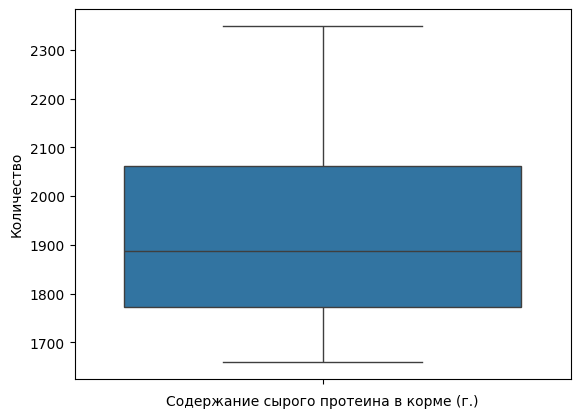

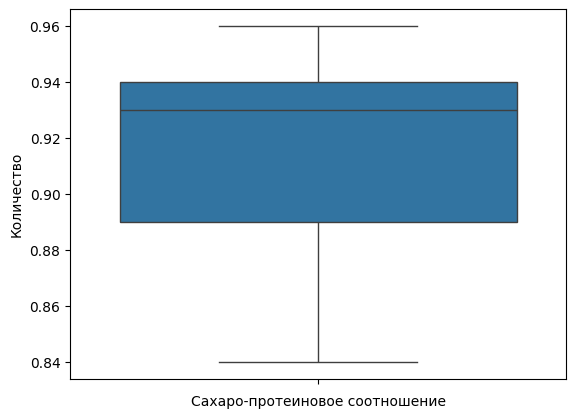

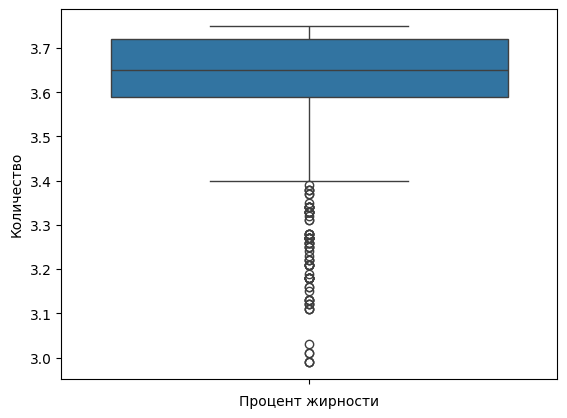

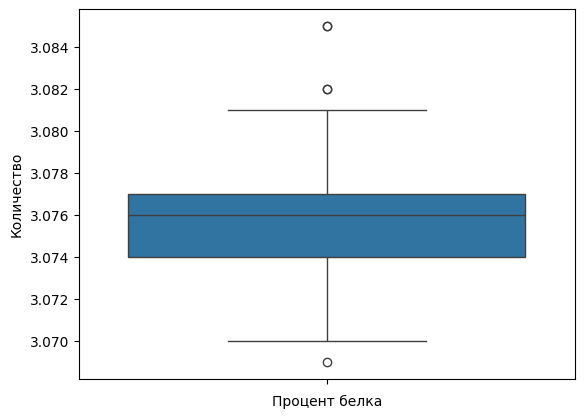

In [71]:
# для отображения количественных признаков буду использовать boxplot
for d in DF_NAMES[:2]:
    if 'cow' in d: c_a = COW_NUM_COL
    if 'main' in d: c_a = MAIN_NUM_COL
    print(f'"Ящик с усами" для таблицы {d}')
    for c in c_a:
        ax = sns.boxplot(y=c, data=globals()[d])
        ax.set(xlabel=c_a[c], ylabel='Количество')
        plt.show()        

## Вывод  

В ходе статистического анализа было выявлено одно аномальное значение и оно удалено.  
Самым неприятным, в смысле дальнейшего анализа, будет являться процент жирности из данных заказчика, в них больше всего аномальных значений меньше первого квартиля. Можно сказать, что % жирности находится в рамках 3.6-3.7, но присутствует много аномальных значений меньше. Процент белка имеет немного аномальных значений и они вряд ли сильно скажится на дальнейшей работе.


# 4. Корреляционный анализ признаков в датасете ferma_main.csv

### Произведу расчет корреляции данных в таблице данных вермы заказчика

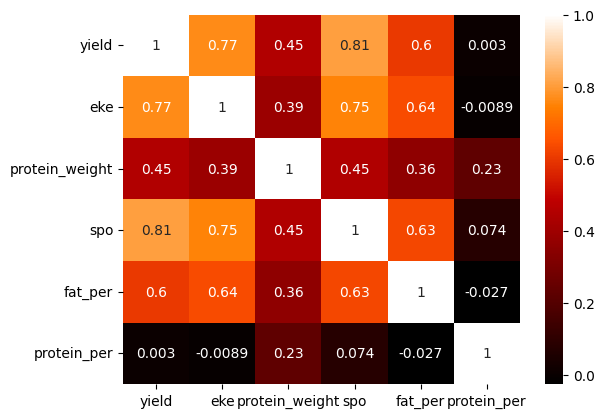

In [72]:
dataplot = sns.heatmap(df_main[MAIN_NUM_COL.keys()].corr(), cmap='gist_heat', annot=True) 

Тут наверное нужен какой-то вывод...

### Построю диаграммы рассеяния для признака "Удой", выявляя взаимосвязи с категориальными данными

C:\Users\abrik\AppData\Local\Temp\ipykernel_19592\1140216474.py:3: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=10,w_pad=3)


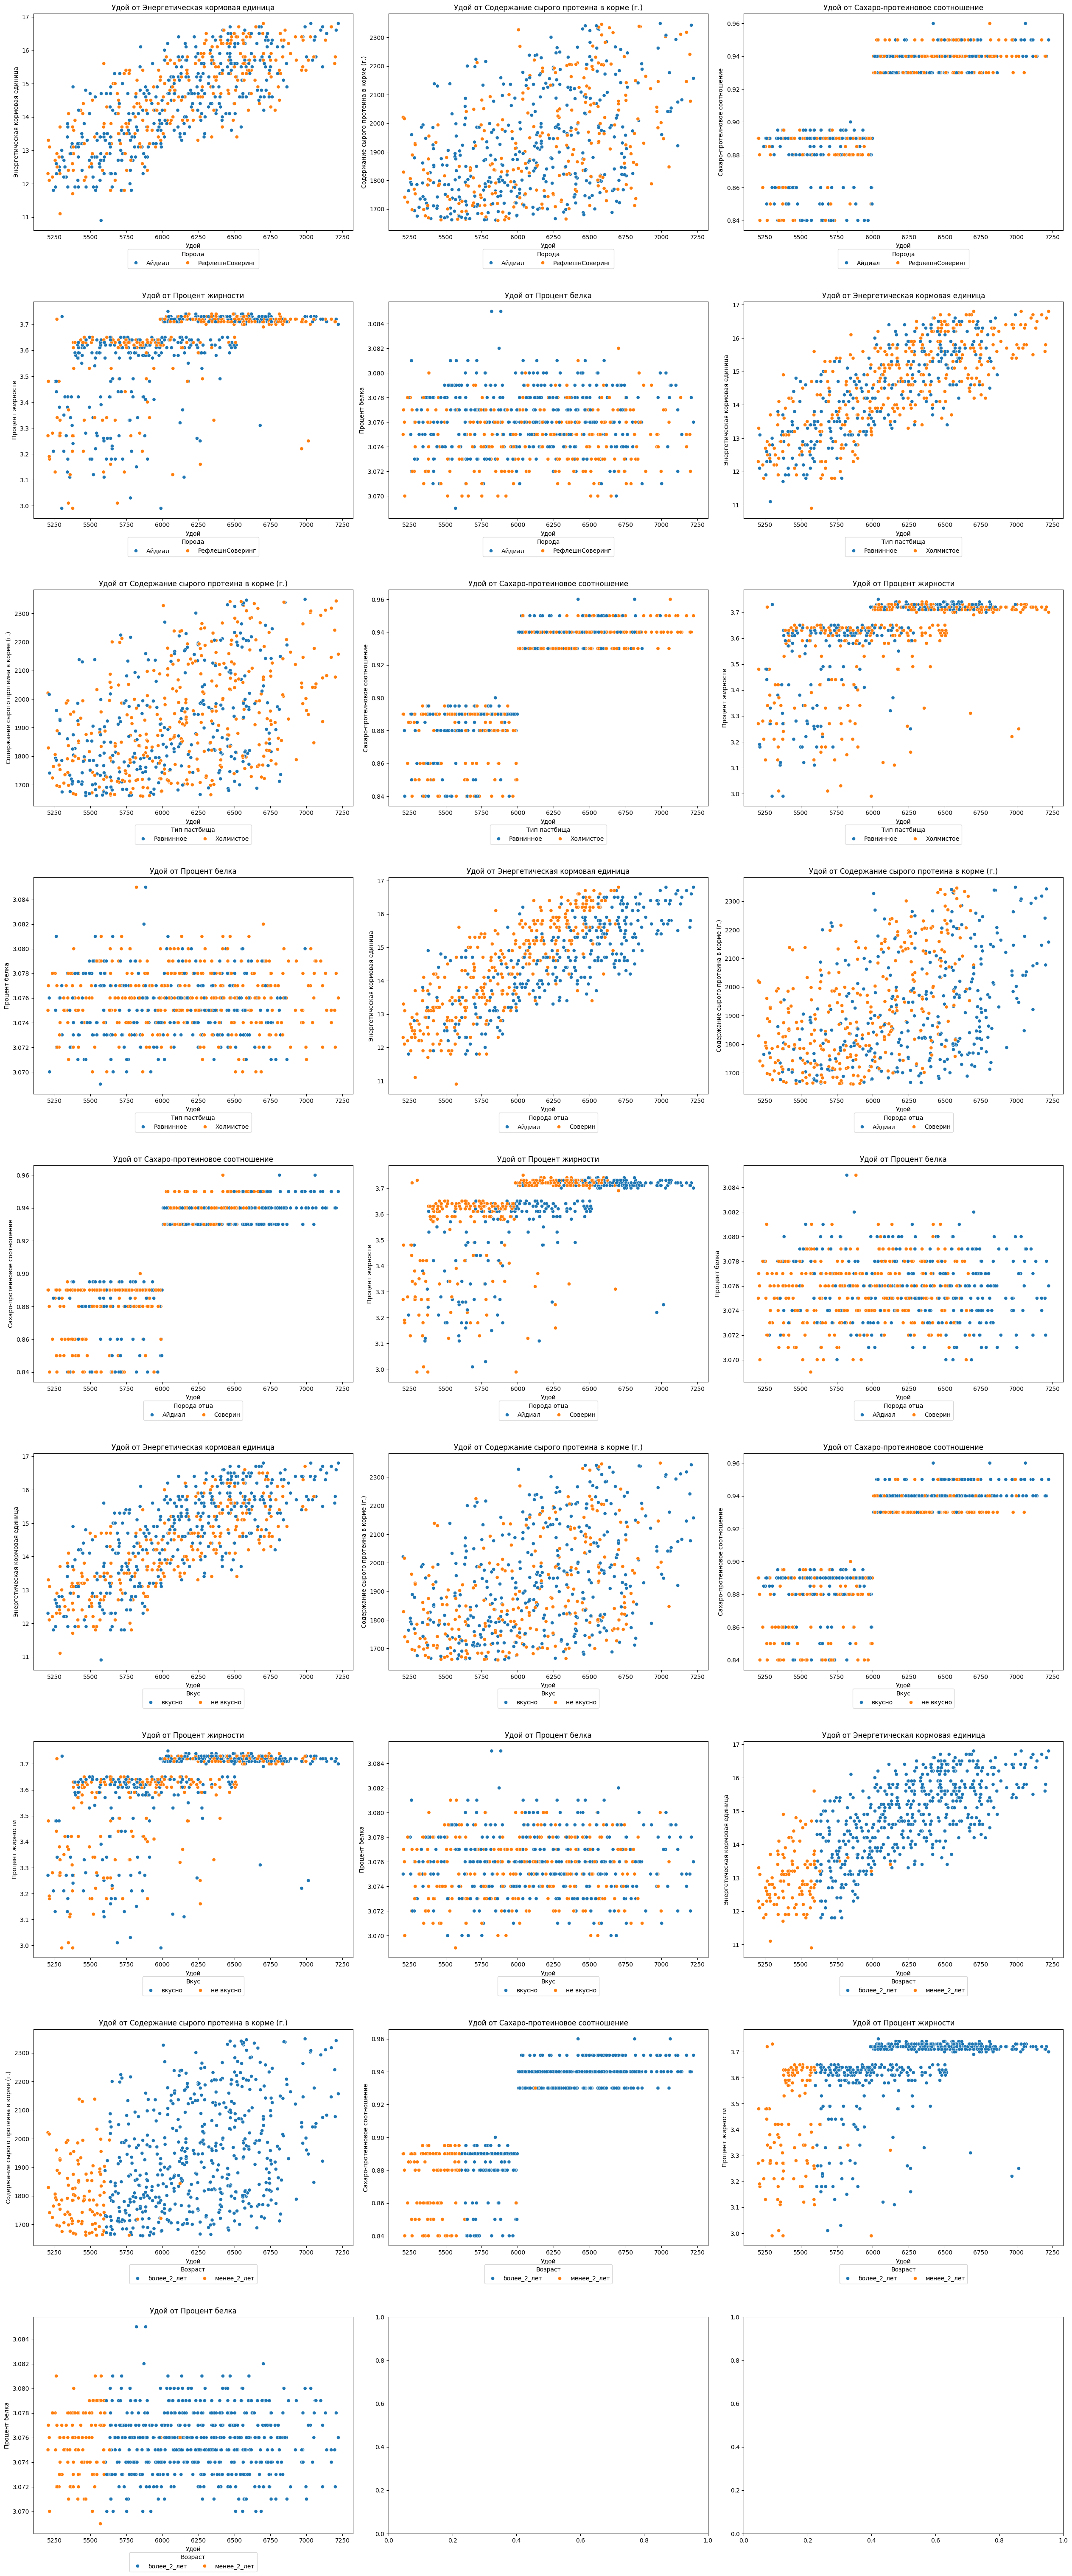

In [73]:
x=0
fig, axes = plt.subplots(9,3, figsize=(25, 60), constrained_layout=True)
fig.tight_layout(h_pad=10,w_pad=3)
axes = axes.ravel()

for c in MAIN_CAT_COL:
    for col in list(MAIN_NUM_COL.keys())[1:]:
        ax = sns.scatterplot(data=df_main, x='yield', y=col, hue=c, ax=axes[x])
        ax.set(xlabel='Удой', ylabel=MAIN_NUM_COL[col], title=('Удой от ' + MAIN_NUM_COL[col]))
        ax.get_legend().set_title(MAIN_CAT_COL[c])
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, -0.19), ncol=3, title=MAIN_CAT_COL[c], frameon=True)
        x+=1

## Вывод  


Устойчивая корреляция наблюдается между удоем и СПО и ЭКЕ, слабеи коррелирует с процентом жирности и массой белка. 
Графики показывают линейную зависимость удоя от ЭКЕ и СПО. Наблюается некая аномалия в графиках с СПО - область делится на два участка, предполагаю, что это говорит о двух типах корма разного качества. По графикам можно заметить, что для всех коров возрастом более 2 лет характерны бОльшие удои. Графики оценивающие процент белка "рассечены" причиной этому ограничение количества знаков в переменной. В графиках с процентом жирности наблюдаются две линии плотности в районе 3.6 и 3.7%, а ниже равномерно распределенные данные. Я считаю, что это из-за особенностей сбора данных. Некоторые собирающие данные для простоты выполнения задачи округляют их в уме до десятков.   
   В дальнейших вычислениях, я полагаю будет целесообразным, признак СПО конвертировать из количественного в категриальный разделив на "КормА" и "КормБ" 

# 5. Задача регрессии

### Первая модель  
В качестве целевого признака по условию я использую Удой. Для обучающих признаков я отобрал следующие:  
|Признак |Причина|  
|:-------|:------|
|ЭКЕ (Энергетическая кормовая единица)|Видна линейная связь на графиках и в корреляции|
|Сырой протеин, г|Свзяли видна на графиках|
|СПО (Сахаро-протеиновое соотношение)|Видна линейная связь на графиках и в корреляции|
|Порода|В числах связи не наблюдаю, но по логике бывают как мясные там и молочные породы|
|Тип пастбища|На некоторых графиках можно заметить, что для холмистого пастбища удои выше|
|порода папы_быка|Логичный параметр и подтверждатеся графиками|
|Возраст|Графики указывают на бОльший удой для старших коров|  

Разобью датасет на тренировочную и тестовую выборки:


R2 LinearRegression = 0.7885037719106386


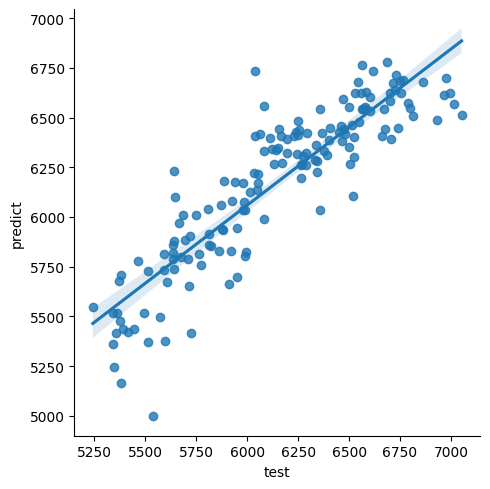

In [74]:
X_columns = ['eke', 'spo', 'protein_weight', 'breed', 'pasture_type', 'breed_dad', 'protein_per', 'age']
num_col = ['eke', 'spo', 'protein_per', 'protein_weight']
cat_col = ['breed', 'pasture_type', 'breed_dad', 'age']

predict, X_test, y_test, m, model1, scaler1, encoder1 = model_func(df=df_main, xcolumns=X_columns, num_col=num_col, cat_col=cat_col)
itogo = pd.DataFrame({'test':y_test, 'predict':predict})
sns.lmplot(x='test',y='predict', data = itogo)
plt.show
r2 = r2_score(y_test, predict)
print("R2 LinearRegression =", r2)
df_metrics.loc[0] = m

[Text(0.5, 0, 'Точность предсказания'),
 Text(0, 0.5, 'Количество'),
 Text(0.5, 1.0, 'Гистограмма точности предсказаний')]

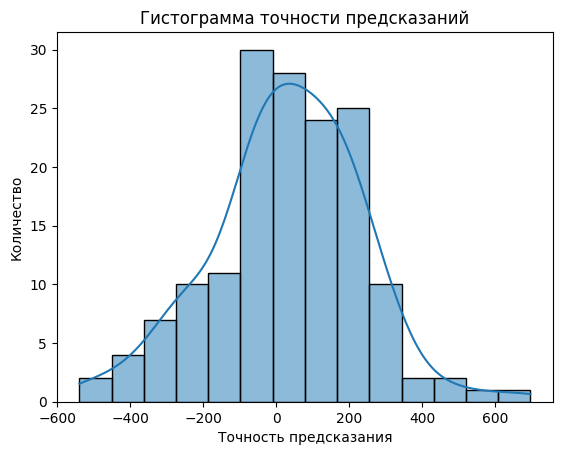

In [75]:
ax = sns.histplot(x=predict-y_test, kde=True)
ax.set(xlabel='Точность предсказания', ylabel='Количество', title='Гистограмма точности предсказаний')

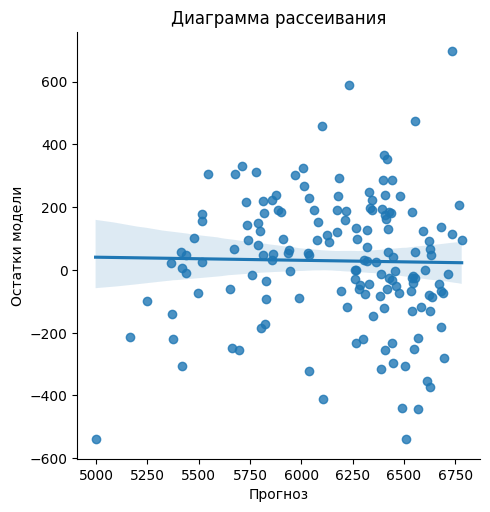

In [76]:
itogo['error'] = itogo['predict']-y_test
ax=sns.lmplot(x='predict',y='error', data = itogo)
ax.set(xlabel='Прогноз', ylabel='Остатки модели', title='Диаграмма рассеивания')

**Вывод:**  
В результате провизведенных исследованиях подель показала вероятность предсказаний 79%. Гистограмма близка к колоколообразной форме, но все же имеет дататочные отклонения, симметрия наблюдается относительно нуля. Диаграмма рассеивания показывает "рупор", модель может работать неустойчиво, поскольку разброс остатков непостоянен. Такую модель использовать в работе нельзя.

### Вторая модель

R2 LinearRegression = 0.8200540453507152


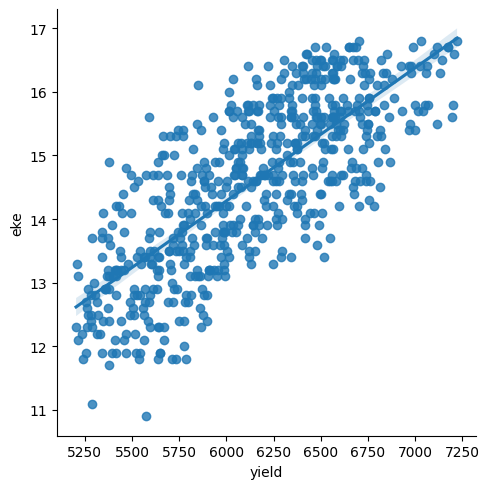

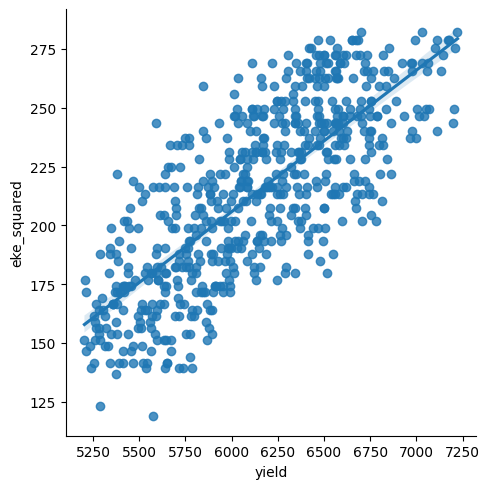

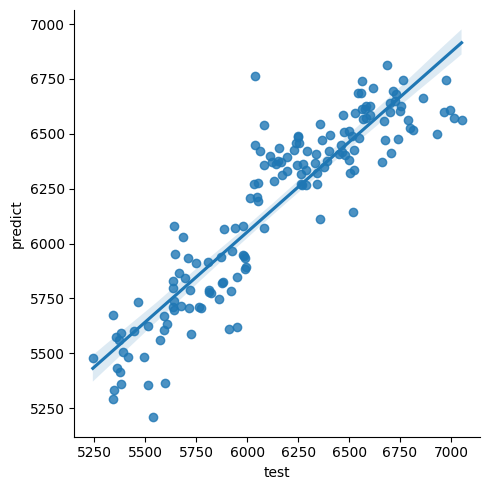

In [77]:
df_main['spo_type'] = 0
df_main.loc[df_main['spo'] > 0.92, 'spo_type'] = 1
df_main['eke_squared'] = df_main['eke']**2
sns.lmplot(x='yield',y='eke', data = df_main)
sns.lmplot(x='yield',y='eke_squared', data = df_main)

X_columns = ['eke_squared', 'spo_type', 'protein_weight', 'breed', 'pasture_type', 'breed_dad', 'protein_per', 'age']
num_col = ['eke_squared', 'protein_per', 'protein_weight']
cat_col = ['breed', 'pasture_type', 'breed_dad', 'age', 'spo_type']

predict, X_test, y_test, m, model2, scaler2, encoder2 = model_func(df=df_main, xcolumns=X_columns, num_col=num_col, cat_col=cat_col)
itogo = pd.DataFrame({'test':y_test, 'predict':predict})
sns.lmplot(x='test',y='predict', data = itogo)
plt.show
r2 = r2_score(y_test, predict)
print("R2 LinearRegression =", r2)
df_metrics.loc[1] = m

[Text(0.5, 0, 'Точность предсказания'),
 Text(0, 0.5, 'Количество'),
 Text(0.5, 1.0, 'Гистограмма точности предсказаний')]

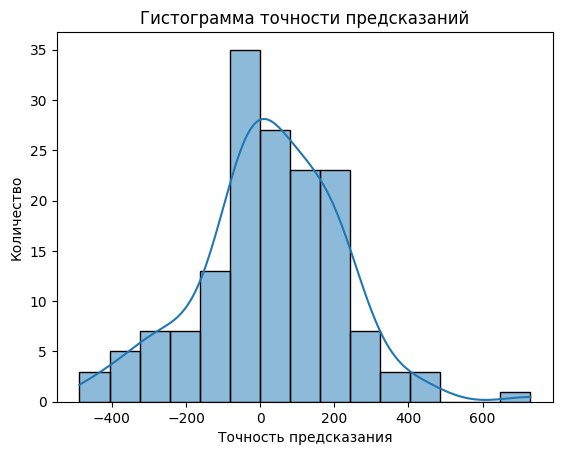

In [78]:
ax = sns.histplot(x=predict-y_test, kde=True)
ax.set(xlabel='Точность предсказания', ylabel='Количество', title='Гистограмма точности предсказаний')

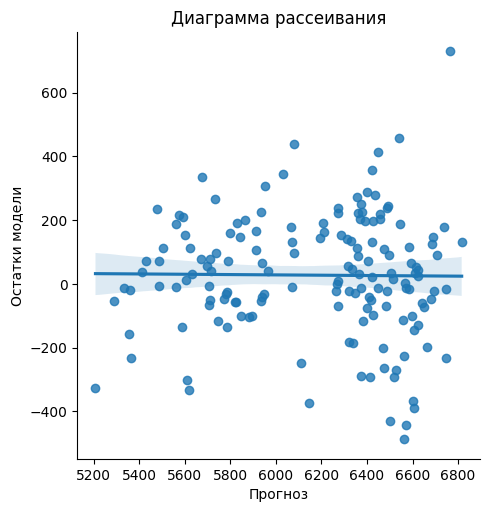

In [79]:
itogo['error'] = itogo['predict']-y_test
ax=sns.lmplot(x='predict',y='error', data = itogo)
ax.set(xlabel='Прогноз', ylabel='Остатки модели', title='Диаграмма рассеивания')

**Вывод:**  
В результате провизведенных исследованиях подель показала вероятность предсказаний 82%. Гистограмма близка к колоколообразной форме, но все же имеет достаточные отклонения, симметрия наблюдается относительно нуля. В правой части наблюдается всплеск. Диаграмма рассеивания показывает уже меньший "рупор". Такую модель использовать в работе нельзя. Считаю, что необходимы дополнительные признаки, которые не были учтены при сборе данных.  

_P.S. Ревьюверу.  
В задании сказано:_  
>Вы обнаружите, что ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.    

_Я построил рассеивание для обоих степеней, но они оба очень линейны. Я что-то сделал не так?_

### Третья модель

R2 LinearRegression = 0.806964482685349


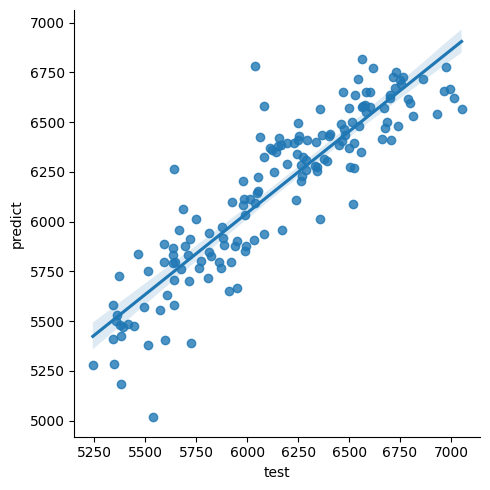

In [80]:
df_dad['id']=df_dad['id'].astype(int)
#print(df_dad.info(verbose=True))
df_main3 = pd.merge(df_main, df_dad, on='id')

X_columns = ['eke_squared', 'spo', 'protein_weight', 'breed', 'pasture_type', 'breed_dad', 'protein_per', 'age', 'dad_name']
num_col = ['eke_squared', 'protein_per', 'spo', 'protein_weight']
cat_col = ['breed', 'pasture_type', 'breed_dad', 'age', 'dad_name']

predict, X_test, y_test, m, model3, scaler3, encoder3 = model_func(df=df_main3, xcolumns=X_columns, num_col=num_col, cat_col=cat_col)
itogo = pd.DataFrame({'test':y_test, 'predict':predict})
sns.lmplot(x='test',y='predict', data = itogo)
plt.show
r2 = r2_score(y_test, predict)
print("R2 LinearRegression =", r2)
df_metrics.loc[2] = m

[Text(0.5, 0, 'Точность предсказания'),
 Text(0, 0.5, 'Количество'),
 Text(0.5, 1.0, 'Гистограмма точности предсказаний')]

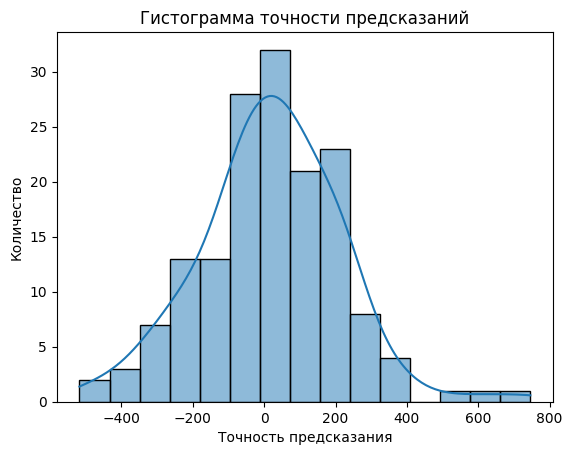

In [81]:
ax = sns.histplot(x=predict-y_test, kde=True)
ax.set(xlabel='Точность предсказания', ylabel='Количество', title='Гистограмма точности предсказаний')

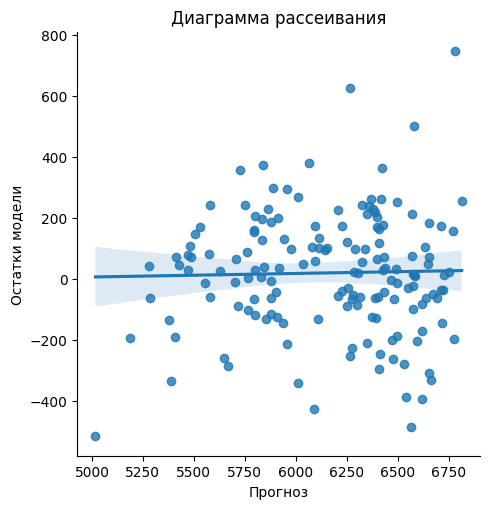

In [82]:
itogo['error'] = itogo['predict']-y_test
ax=sns.lmplot(x='predict',y='error', data = itogo)
ax.set(xlabel='Прогноз', ylabel='Остатки модели', title='Диаграмма рассеивания')

**Вывод:**  
В результате провизведенных исследованиях модель показала вероятность предсказаний 82%. Гистограмма колоколообразной формы, за исключением всплеска справа. Симметрия наблюдается относительно нуля. Диаграмма рассеивания по-прежнему "рупор".   

_P.S. Ревьюверу.  
Подскажи пожалуста как избавиться от рупорности и всплеска справа. И нужно ли это? Спасибо._

### 4. Сравнение по R2  
Первая модель по метрике R2 показывает лучший результат

### 5. Сравнение трех моделей   
Для всех трех моделей характерна небольшая рупорность в диаграмме рассеяния ошибок. Последняя модель показывает не лучший показатель R2, однако, диаграмма рассеяности и гистограма распределения ошибок указывает, что эта модель более стабильна.

In [83]:
display(df_metrics)

mse         mae        rmse
0  43053.222163  161.845801  207.492704
1  36630.691870  146.817317  191.391462
2  39295.268230  152.030068  198.230341

По всем трем метрикам вторая модель показывает лучшие результаты.

### 6. Прогнозирую удой коров для покупки

In [84]:
eke = df_main3['eke_squared'].mean()
print(eke)
df_cow['eke'] = eke + eke/20
spo = df_main3['spo'].mean()
df_cow['spo'] = spo + spo/20
protein_weight = df_main3['protein_weight'].mean()
df_cow['protein_weight'] = protein_weight + protein_weight/20

213.35735668789806


In [85]:
display(df_main)

id  yield   eke  protein_weight    spo            breed pasture_type  \
0      1   5863  14.2            1743  0.890           Айдиал    Равнинное   
1      2   5529  12.8            2138  0.890           Айдиал    Равнинное   
2      3   5810  14.0            1854  0.885  РефлешнСоверинг    Холмистое   
3      4   5895  12.4            2012  0.885  РефлешнСоверинг    Холмистое   
4      5   5302  12.8            1675  0.885           Айдиал    Равнинное   
..   ...    ...   ...             ...    ...              ...          ...   
624  625   6812  15.4            1964  0.940  РефлешнСоверинг    Равнинное   
625  626   5513  12.9            1700  0.880  РефлешнСоверинг    Равнинное   
626  627   5970  14.4            1837  0.880  РефлешнСоверинг    Холмистое   
627  628   5746  13.8            1994  0.890  РефлешнСоверинг    Равнинное   
628  629   6503  16.2            2283  0.940           Айдиал    Холмистое   

    breed_dad  fat_per  protein_per      taste          age  spo_type  \
0      Айдиал     3.58        3.076     вкусно  более_2_лет         0   
1     Соверин     3.54        3.079     вкусно  менее_2_лет         0   
2     Соверин     3.59        3.074  не вкусно  более_2_лет         0   
3      Айдиал     3.40        3.075  не вкусно  более_2_лет         0   
4     Соверин     3.73        3.073     вкусно  менее_2_лет         0   
..        ...      ...          ...        ...          ...       ...   
624    Айдиал     3.74        3.075  не вкусно  более_2_лет         1   
625   Соверин     3.64        3.073     вкусно  менее_2_лет         0   
626   Соверин     3.64        3.075  не вкусно  более_2_лет         0   
627   Соверин     3.64        3.077     вкусно  более_2_лет         0   
628   Соверин     3.71        3.076     вкусно  более_2_лет         1   

     eke_squared  
0         201.64  
1         163.84  
2         196.00  
3         153.76  
4         163.84  
..           ...  
624       237.16  
625       166.41  
626       207.36  
627       190.44  
628       262.44  

[628 rows x 14 columns]

In [86]:
df_cow = df_cow.loc[:,['eke', 'spo', 'protein_weight', 'breed', 'pasture_type', 'breed_dad', 'protein_per', 'age', 'dad_name']]
num_col = ['eke', 'protein_per', 'spo', 'protein_weight']
cat_col = ['breed', 'pasture_type', 'breed_dad', 'age', 'dad_name']
X = np.concatenate((scaler3.fit_transform(df_cow[num_col]), 
                              encoder3.fit_transform(df_cow[cat_col])), axis=1)


yield_p = model3.predict(X)
display(yield_p)

array([6355.12027363, 6091.29706059, 5956.89746799, 6375.79269467,
       6254.0884803 , 6186.48307715, 6296.00244651, 6119.65247587,
       6137.29593581, 6320.46556786, 6451.56058529, 5846.50650967,
       6362.93398645, 6060.14368649, 6186.48307715, 6328.14921707])

# 6. Задача классификации

### 1. Подготовка и обучение модели логической регрессии.   
Подготовлю переменные содержащие списки столбцов категриальных и числовых данных.

In [87]:
cat_col = ['pasture_type', 'breed_dad' ]
num_col = ['protein_per']

df_main3.loc[df_main3['taste']=='вкусно', 'taste'] = 1
df_main3.loc[df_main3['taste']=='не вкусно', 'taste'] = 0
df_main3 = df_main3.astype({'taste': int})


Обратившись к объявленной функции получаю: модель, accuracy, recall, precision и матрицу ошибок.  
По матрице ошибок построю график.

In [88]:
encoder, scaler, accuracy, recall, precision, cm, porog, clf = cat_model_func(df_main3, num_col, cat_col, 'taste')
for feature_number, feature_name in enumerate(num_col+cat_col):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.6f}") 


protein_per         : +1.308522
pasture_type        : +0.739495
breed_dad           : +1.350149


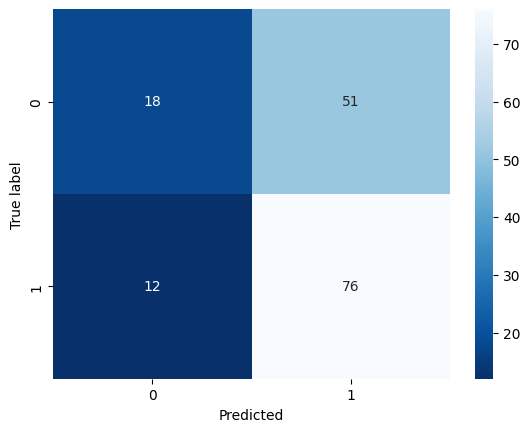

Accuracy = 0.599; Recall = 0.864; Precission = 0.598


In [89]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 
plt.show()
print(f'Accuracy = {accuracy:0.3f}; Recall = {recall:0.3f}; Precission = {precision:0.3f}')


### 2. Анализ модели логической регрессии.  

Для заказчика важно чтобы молко коровы было вкусным. Переведя на язык модели можно сказать важно, чтобы модель не предсказало молоко вкусным, когда оно по факту окажется не вкусным. То есть ложноположительный результат. Это есть ошибка первого рода. Для дальнейших расчетов мне нужна метрика **precision**.  

Произведу подбор оптимального порога принадлежности.

In [90]:
columns = []

for i in [round(i,2) for i in np.linspace(0.5,1,num = 10,endpoint=False)]:
	columns.append('y_pred_'+str(i))
	porog['y_pred_'+str(i)] = porog['y_proba'].apply(lambda x: 1 if x >= i else 0)
print(porog.groupby('y_valid').sum().iloc[:,1:])

         y_pred_0.5  y_pred_0.55  y_pred_0.6  y_pred_0.65  y_pred_0.7  \
y_valid                                                                 
0                51           43          28           19           9   
1                76           65          56           37          16   

         y_pred_0.75  y_pred_0.8  y_pred_0.85  y_pred_0.9  y_pred_0.95  
y_valid                                                                 
0                  1           0            0           0            0  
1                  3           0            0           0            0  


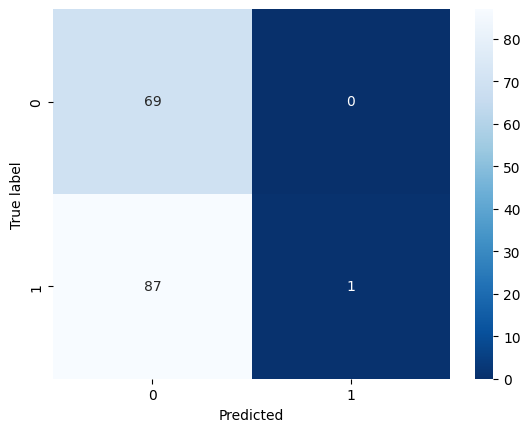

Accuracy = 0.446; Recall = 0.011; Precission = 1.000


In [91]:
threshold=0.77
encoder, scaler, accuracy, recall, precision, cm, porog, clf = cat_model_func(df_main3, num_col, cat_col, 'taste',threshold=threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 
plt.show()
print(f'Accuracy = {accuracy:0.3f}; Recall = {recall:0.3f}; Precission = {precision:0.3f}')

При пороге в 0.7 получаем 0 ложных срабатываний, все коровы с вусным молоком. Но при этом их количество не велико. Вероятно имеется некий признак более ярко влияющий на вкусовые качества. Было бы неплохо его подобрать.

### 3. С помощью обученной модели спрогнозирую вкус молока коров у коров представленных на продажу.

In [92]:

x = np.hstack([scaler.fit_transform(df_cow[num_col]), 
              encoder.fit_transform(df_cow[cat_col])])
predict = (clf.predict_proba(x)[:,1] > threshold).tolist()
display(predict)


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [93]:
print()

# 7. Вывод

### 1. Добавлю прогнозы вкуса момлока и удоя в  датафрейм с коровами, покупку которых рассматривает фермер.

In [94]:
display(df_cow.shape)
df_cow['taste']=predict
df_cow['yield'] = yield_p
display(df_cow)

(16, 9)

eke       spo  protein_weight            breed pasture_type  \
0   224.025225  0.958744     2019.947532           Айдиал    холмистое   
1   224.025225  0.958744     2019.947532           Айдиал    равнинное   
2   224.025225  0.958744     2019.947532  РефлешнСоверинг    равнинное   
3   224.025225  0.958744     2019.947532  РефлешнСоверинг    холмистое   
4   224.025225  0.958744     2019.947532  РефлешнСоверинг    равнинное   
5   224.025225  0.958744     2019.947532  РефлешнСоверинг    равнинное   
7   224.025225  0.958744     2019.947532           Айдиал    равнинное   
9   224.025225  0.958744     2019.947532  РефлешнСоверинг    холмистое   
10  224.025225  0.958744     2019.947532           Айдиал    холмистое   
11  224.025225  0.958744     2019.947532  РефлешнСоверинг    равнинное   
12  224.025225  0.958744     2019.947532           Айдиал    холмистое   
13  224.025225  0.958744     2019.947532           Айдиал    холмистое   
15  224.025225  0.958744     2019.947532  РефлешнСоверинг    холмистое   
16  224.025225  0.958744     2019.947532           Айдиал    холмистое   
17  224.025225  0.958744     2019.947532  РефлешнСоверинг    равнинное   
18  224.025225  0.958744     2019.947532           Айдиал    равнинное   

   breed_dad  protein_per          age  dad_name  taste        yield  
0     Айдиал        3.076  более_2_лет  Геркулес  False  6355.120274  
1    Соверин        3.081  менее_2_лет    Буйный  False  6091.297061  
2    Соверин        3.074  более_2_лет     Барин  False  5956.897468  
3     Айдиал        3.061  более_2_лет    Буйный  False  6375.792695  
4     Айдиал        3.074  более_2_лет    Буйный  False  6254.088480  
5    Соверин        3.053  менее_2_лет  Геркулес  False  6186.483077  
7    Соверин        3.079  более_2_лет    Буйный  False  6296.002447  
9     Айдиал        3.079  менее_2_лет    Буйный  False  6119.652476  
10   Соверин        3.055  более_2_лет  Соловчик  False  6137.295936  
11   Соверин        3.073  более_2_лет  Геркулес  False  6320.465568  
12    Айдиал        3.046  более_2_лет  Геркулес  False  6451.560585  
13   Соверин        3.075  менее_2_лет     Барин  False  5846.506510  
15    Айдиал        3.065  более_2_лет    Буйный  False  6362.933986  
16   Соверин        3.079  более_2_лет  Соловчик  False  6060.143686  
17   Соверин        3.053  менее_2_лет  Геркулес  False  6186.483077  
18   Соверин        3.069  более_2_лет    Буйный  False  6328.149217

### 2. Вывод по запрошенным параметрам.  
Согласно строгому условию заказчика удой должен быть не менее 6000 кг\год, а молоко исключительно вкусным. Но в расчетах я не смог добиться метрики выдающей только вкусное молоко. Поэтому в предоставленных 19 коровах нет подходящей.

### 3. Выводы о моделях линейной регрессии.  
Для улучшения регрессионной модели я отбирал признаки сильно влияющие на ее качество. Для улучшения качества модели меобходим массив с еще большими наблюдениями. При анализе рисков или экономических расчётов для задач классификации фажны метрики recall и precision (первая отвечает за наполненность, а вторая за точность), а для линейной регрессии MSE, MAE, RMSE.